In [1]:
# limits the GPU so that it does not crash
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

**Creating the model**

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = [224, 224]

In [4]:
train_directory  = "./dataset/train"
test_directory = "./dataset/test"
val_directory = "./dataset/valid"

In [5]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [6]:
# useful for getting number of classes
folders = glob('./dataset/train/*')
len(folders)

525

In [7]:
# our layers
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [8]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_directory,
                                                 target_size=(244, 244),
                                                 batch_size=32,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory(test_directory,
                                                 target_size=(244, 244),
                                                 batch_size=32,
                                                 class_mode='categorical')


Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [11]:
print(len(training_set))
print(len(test_set))

2645
83


In [12]:
r = model.fit(
    training_set,
    validation_data=test_set,
    epochs=8,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Epoch 1/8
2645/2645 [==============================] - 836s 312ms/step - loss: 6.3923 - accuracy: 0.3240 - val_loss: 3.7366 - val_accuracy: 0.5775
Epoch 2/8
2645/2645 [==============================] - 922s 348ms/step - loss: 4.1765 - accuracy: 0.5531 - val_loss: 3.7431 - val_accuracy: 0.6149
Epoch 3/8
2645/2645 [==============================] - 1121s 424ms/step - loss: 3.4024 - accuracy: 0.6399 - val_loss: 3.5991 - val_accuracy: 0.6632
Epoch 4/8
2645/2645 [==============================] - 957s 362ms/step - loss: 2.9658 - accuracy: 0.6910 - val_loss: 3.5000 - val_accuracy: 0.6968
Epoch 5/8
2645/2645 [==============================] - 906s 343ms/step - loss: 2.5937 - accuracy: 0.7300 - val_loss: 3.4554 - val_accuracy: 0.7158
Epoch 6/8
2645/2645 [==============================] - 913s 345ms/step - loss: 2.3008 - accuracy: 0.7614 - val_loss: 3.4193 - val_accuracy: 0.7333
Epoch 7/8
2645/2645 [==============================] - 897s 339ms/step - loss: 2.0860 - accuracy: 0.7844 - val_loss: 

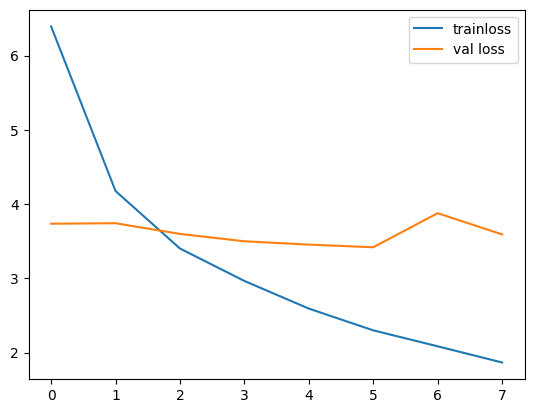

In [13]:
plt.plot(r.history['loss'], label='trainloss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

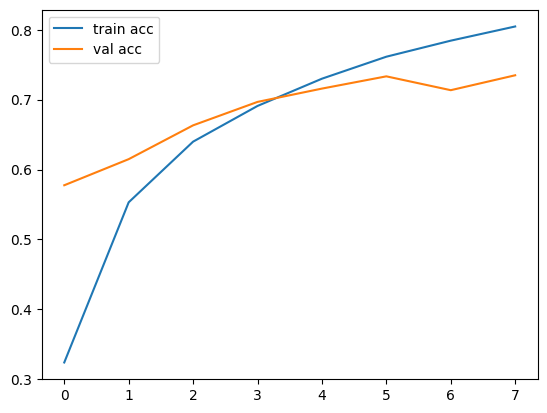

[0.5775238275527954, 0.6148571372032166, 0.6632381081581116, 0.6967619061470032, 0.7158095240592957, 0.7333333492279053, 0.713523805141449, 0.7348571419715881]


In [20]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [15]:
model.save('model/BirdClassification.h5')

**Testing the saved model**

In [16]:
from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array

model1 = load_model('./model/BirdClassification.h5', compile=False)

In [17]:
lab = training_set.class_indices
lab = {k:v for v,k in lab.items()}

In [18]:
def output(location):
    img = load_img(location, target_size=(224, 224, 3))
    img = img_to_array(img)
    img = img/255
    img = np.expand_dims(img, [0])
    answer = model1.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = lab[y]
    return res

In [ ]:
img = input("Please enter the path of an image: ")
pic = load_img(img)
plt.imshow(pic)
output(img)